In [83]:
# config
fits_base_dir = '/Users/Shared/oca_data/fits'  # /data/fits
telescope = 'jk15'
fltr = 'V'
master_flat = 'jk15c_0688_90272' # V
# master_flat = 'jk15c_0673_49682'   # Ha
# master_flat = 'jk15c_0721_49734'  # z

# Shutter map from random FLATS series

In [84]:
from pathlib import Path
from astropy.io import fits as pyfits
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy import stats

In [85]:
flats_series_path = Path(fits_base_dir) / telescope / 'processed-ofp/flats' / fltr / master_flat

Helper function for fast vectorized liner regression on masked arrays
`x_ma` and `y_ma` are 2D masked arrays of shape (n, m), where `n` is the number of images, and `m` is the number of pixels in each image.

In [86]:
import numpy as np
import numpy.ma as ma
import time

def ultra_optimized_masked_lstsq(A, Np_masked):
    """
    Ultra-optimized solution for n=7, k=2 with millions of columns.
    Groups columns by masking patterns and solves each pattern once.

    This approach is significantly faster than processing each column separately
    because it identifies common mask patterns and reuses calculations.

    Args:
        A: design matrix, shape=(n, 2)
        Np_masked: masked data matrix, shape=(n, m)

    Returns:
        X: coefficient matrix, shape=(2, m)
    """
    start_time = time.time()
    n, m = Np_masked.shape
    k = A.shape[1]
    X = np.zeros((k, m))

    # Extract mask and data from masked array
    if ma.is_masked(Np_masked):
        mask = Np_masked.mask
        data = Np_masked.data
    else:
        # If input is not masked, create a dummy mask (all False)
        mask = np.zeros((n, m), dtype=bool)
        data = Np_masked

    # For each unique mask pattern, find all columns that match
    # Convert column masks to integers for efficient lookup
    # Each column's mask pattern is encoded as a single integer
    # with bits representing which rows are masked
    mask_patterns = np.zeros(m, dtype=np.int32)
    for i in range(n):
        # Use bit shifting to create a unique integer for each mask pattern
        # Example: if row 0 and 2 are masked: 1 + 4 = 5 (binary 101)
        mask_patterns += (mask[i, :].astype(np.int32) << i)

    # Find unique patterns and map them to column indices
    unique_patterns, inverse_indices = np.unique(mask_patterns, return_inverse=True)
    # Create a dictionary mapping each pattern to its column indices
    pattern_to_cols = {p: np.where(mask_patterns == p)[0] for p in unique_patterns}

    print(f"Found {len(unique_patterns)} unique masking patterns")
    print(f"Pattern identification time: {time.time() - start_time:.4f}s")

    # For each pattern, calculate pseudoinverse once to reuse
    pattern_to_pinv = {}

    for pattern in unique_patterns:
        # Convert integer pattern back to boolean array
        # Example: 5 (binary 101) means rows 0 and 2 are masked
        pattern_array = np.array([bool(pattern & (1 << i)) for i in range(n)])
        # We need valid (unmasked) rows for calculation
        valid_rows = ~pattern_array

        # Skip patterns with insufficient data points
        if np.sum(valid_rows) < k:
            continue

        # Get valid rows from design matrix
        A_valid = A[valid_rows, :]

        # Calculate pseudoinverse for this pattern
        if np.sum(valid_rows) > k:
            # Overdetermined system (more equations than unknowns)
            # Use pseudoinverse for least squares solution
            pattern_to_pinv[pattern] = np.linalg.pinv(A_valid)
        else:
            # Exactly determined system (equations = unknowns)
            # Use regular inverse for direct solution
            try:
                pattern_to_pinv[pattern] = np.linalg.inv(A_valid)
            except np.linalg.LinAlgError:
                # Skip singular matrices that cannot be inverted
                continue

    print(f"Pseudoinverse calculation time: {time.time() - start_time:.4f}s")

    # Process each column pattern
    for pattern, cols in pattern_to_cols.items():
        # Skip patterns that couldn't be inverted
        if pattern not in pattern_to_pinv:
            continue

        # Get the precomputed pseudoinverse
        pinv = pattern_to_pinv[pattern]
        # Convert pattern back to boolean array
        pattern_array = np.array([bool(pattern & (1 << i)) for i in range(n)])
        valid_rows = ~pattern_array

        # Process columns in batches to avoid memory issues
        # This is crucial for large datasets with millions of columns
        batch_size = 1000000  # Adjust based on available memory
        for i in range(0, len(cols), batch_size):
            batch_cols = cols[i:i+batch_size]
            # Extract data for current batch (only valid rows)
            batch_data = data[valid_rows][:, batch_cols]

            # Calculate solutions: pinv @ data
            # This is the key computation: applying the pseudoinverse
            # to all columns with the same mask pattern at once
            X_batch = pinv @ batch_data
            # Store results in the output matrix
            X[:, batch_cols] = X_batch

            print(f"Processed batch {i//batch_size + 1}/{(len(cols) + batch_size - 1)//batch_size} "
                  f"for pattern {pattern}, time: {time.time() - start_time:.4f}s")

    total_time = time.time() - start_time
    print(f"Total time: {total_time:.4f}s")
    return X

def super_fast_without_mask(A, Np):
    """
    Solves the equation A @ X = Np for each column of Np separately,
    without considering masking.

    This function uses NumPy's built-in least squares solver, which is optimized
    for the non-masked case. It's significantly faster than the masked version
    but doesn't handle missing data correctly.

    Args:
        A: design matrix, shape=(n, 2)
        Np: data matrix, shape=(n, m)

    Returns:
        X: coefficient matrix, shape=(2, m)
    """
    # Use NumPy's built-in least squares solver
    # Much faster than the masked version, but doesn't handle missing data
    X = np.linalg.lstsq(A, Np, rcond=None)[0]
    return X

### Collecting data
Flat Field serie:

In [87]:
flat_files = list(flats_series_path.glob(f'{telescope}?_????_?????.fits'))
print('\n'.join([f.name for f in flat_files]))

jk15c_0688_90272.fits
jk15c_0688_90077.fits
jk15c_0688_90175.fits
jk15c_0688_89847.fits
jk15c_0688_89499.fits
jk15c_0688_89704.fits
jk15c_0688_89971.fits


Master ZERO (BIAS) and DARK frames

In [88]:
zero_file_pattern = f'{telescope}?_????_?????_master_z.fits'
dark_file_pattern = f'{telescope}?_????_?????_master_d.fits'
zero_file = list(flats_series_path.glob(zero_file_pattern))[0]
dark_file = list(flats_series_path.glob(dark_file_pattern))[0]

zero = pyfits.open(zero_file)[0].data
# dark data and exptime
dark_hdu = pyfits.open(dark_file)[0]
dark = dark_hdu.data
dark_exptime = float(dark_hdu.header['EXPTIME'])

print(f"Zero frame: {zero_file.name}")
print(f"Dark frame: {dark_file.name}   exptime={dark_exptime}")

Zero frame: jk15c_0688_85238_master_z.fits
Dark frame: jk15c_0672_81664_master_d.fits   exptime=600.0


Load files data into numpy qube $D$, and exposure time vector $t$

In [89]:
_data = []
_exptime = []
for p in flat_files:
    with pyfits.open(p) as hdul:
        _exp  = float(hdul[0].header['EXPTIME'])
        print(f'Loading {p.name} exptime={_exp}')
        d = hdul[0].data - zero - dark * _exp / dark_exptime
        _data.append(d)
        _exptime.append(_exp)
D = np.array(_data)
t = np.array(_exptime)
del _data, _exptime

Loading jk15c_0688_90272.fits exptime=7.840201960371446
Loading jk15c_0688_90077.fits exptime=16.152285936483242
Loading jk15c_0688_90175.fits exptime=11.261793625958573
Loading jk15c_0688_89847.fits exptime=36.50228621939623
Loading jk15c_0688_89499.fits exptime=107.68650457173034
Loading jk15c_0688_89704.fits exptime=58.06803640370336
Loading jk15c_0688_89971.fits exptime=23.74066412362226


In [90]:
D.shape, t.shape

((7, 4096, 4108), (7,))

### Calculations
#### Normalization

We are looking for median flux vector $F_i = M_i/t_i$ for each image, where $M_i$ is the median ADU of $i$-th image, and $t_i$ is the exposure time of $i$-th image.


In [91]:
M = np.median(D, axis=(1, 2))
F = M / t


Check the values of delivered vectors

In [92]:
for _file, _exp, _flux, _median in zip(flat_files, t, F, M):
    print (f'{_file.name}   median={_median:8.2f} ADU   exp={_exp:7.2f}s   flux={_flux:8.2f} ADU/s')

jk15c_0688_90272.fits   median=48413.90 ADU   exp=   7.84s   flux= 6175.08 ADU/s
jk15c_0688_90077.fits   median=49629.78 ADU   exp=  16.15s   flux= 3072.62 ADU/s
jk15c_0688_90175.fits   median=49062.90 ADU   exp=  11.26s   flux= 4356.58 ADU/s
jk15c_0688_89847.fits   median=51822.97 ADU   exp=  36.50s   flux= 1419.72 ADU/s
jk15c_0688_89499.fits   median=56227.28 ADU   exp= 107.69s   flux=  522.14 ADU/s
jk15c_0688_89704.fits   median=53056.90 ADU   exp=  58.07s   flux=  913.70 ADU/s
jk15c_0688_89971.fits   median=50768.72 ADU   exp=  23.74s   flux= 2138.47 ADU/s


We normalize data cube $D$ by mean flux $F$, to left only effects of exposure time, shutter, and optics on ADU, but not she effects of sky brightness.
Normalized cube: $N_{xyi} = D_{xyi}/F_i$


In [93]:
N = (D/F[:, None, None])

### Masking
We are going to mask outliers in order to exclude them from fitting process.

First lets find normalize values of $D$ cube to have unit median.
$Q_{ixy} = D_{ixy} / M_i$
This will equalize median values of all images allowing to find outliers in each column.

Note, that this normalization differs from previous one, we are removing efect of exposure time here!

In [94]:
Q = D / M[:, None, None]

Now calculate median $\mu$ and $\sigma$ of each column (along $i$) as preparation of finding outliers in columns:

$\mu_{xy} = \text{median}(Q_{xy})$, $\sigma_{xy} = \text{std}(Q_{xy})$

In [95]:
Qm = np.mean(Q, axis=(0))
Qs = np.std(Q, axis=(0))

now, we will create mask $R$ of outliers, excluding values outside of $[Qm_{xy} - n \cdot Qs_{xy}, Qm_{xy} + n \cdot Qs_{xy}]$ range.

In [96]:
n = 2.2 # number of sigmas
R = np.logical_and(Qm - n * Qs < Q, Q < Qm + n * Qs)

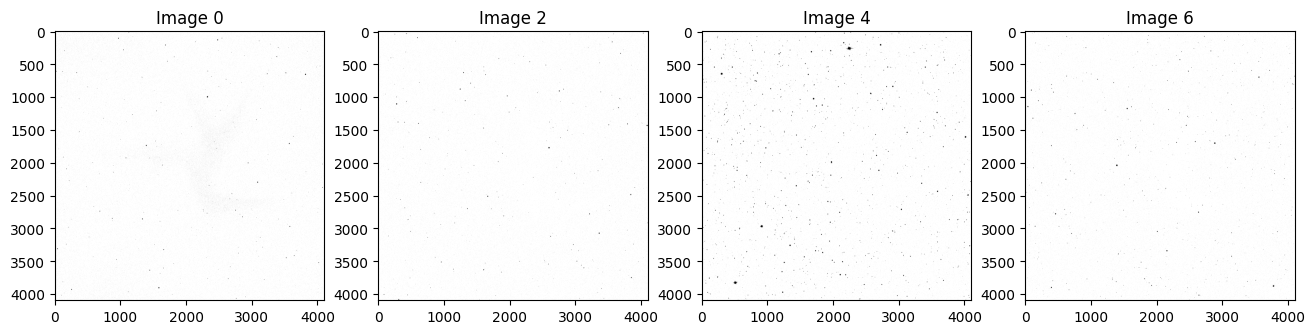

In [97]:
# plot masks for four images
# chose 4 indices uniformly from the range of images
idxs = np.linspace(0, R.shape[0]-1, 4).astype(int)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, idx in enumerate(idxs):
    ax[i].imshow(R[idx], cmap='gray')
    ax[i].set_title(f'Image {idx}')


### Fitting $N_{ixy}(t_i)$

For each pixel, we are looking for linear fit across all images, such that $N_{ixy} = a_{xy} t_i + b_{xy}$, where $N$ is a cube of normalized values.

For technical reasons, we will reshape $N$ to 2D array $N'$, where $N'_{ij} = N_{ixy}$, and $j = x + y \cdot 4096$ (if CCD is 4096x4096 pixels).

In [98]:
Np = N.reshape(N.shape[0], -1)
Rp = R.reshape(R.shape[0], -1)
Np.shape

(7, 16826368)

The problem now has a from of $N' = A X$, where $A$ is a projection matrix of $t_i$ values, and $X$ is a coefficient matrix of $a_{xy}$ and $b_{xy}$ values.

In [99]:
A = np.vstack([t, np.ones_like(t)]).T
print(np.matrix(A), f' shape={A.shape}')

[[  7.84020196   1.        ]
 [ 16.15228594   1.        ]
 [ 11.26179363   1.        ]
 [ 36.50228622   1.        ]
 [107.68650457   1.        ]
 [ 58.0680364    1.        ]
 [ 23.74066412   1.        ]]  shape=(7, 2)


We are looking for $X$ such that $X = (A^T A)^{-1}  A^T  N'$. We will use `numpy.linalg.lstsq` to solve this problem in a least squares sense.

In [100]:
# _b, _a = vectorized_linear(A, ma.array(Np, mask=~Rp))
# X = np.vstack([_a, _b])

# A, shape=(n, 2),
# Np, shape=(n, m),  should be masked in future !!
# X, shape=(2, m)

# X, residuals, rank, s = np.linalg.lstsq(A,  ma.array(Np, mask=~Rp), rcond=None)
# print(f' shape={X.shape}')

Npm = ma.array(Np, mask=~Rp)
# X = ultra_optimized_masked_lstsq(A, Npm)
X = super_fast_without_mask(A, Npm)

Lets, examine histograms of $a_{xy}$ and $b_{xy}$ values, and the same histogram with single clipped outliers. (4 subplots)

Reshape back, and restore vectors $a_{xy}$ and $b_{xy}$.

In [101]:
a = X[0].reshape(N.shape[1:])
b = X[1].reshape(N.shape[1:])
print(a.shape, b.shape)

(4096, 4108) (4096, 4108)


Plot some horizontal intersections of $a_{xy}$ and $b_{xy}$ values.

### Plot map of $b_{xy}$ values

We will use aggresive color scale to see the details not disturbed by outliers.

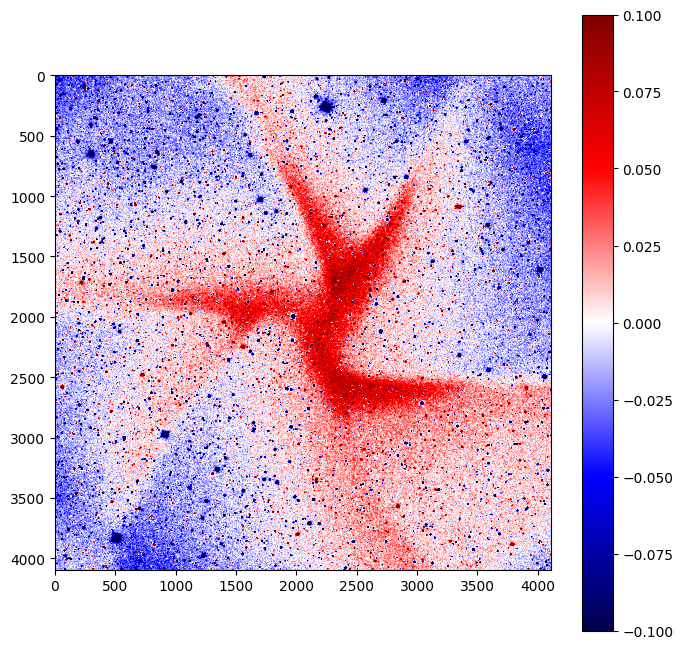

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(b, cmap='seismic', vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)
plt.show()

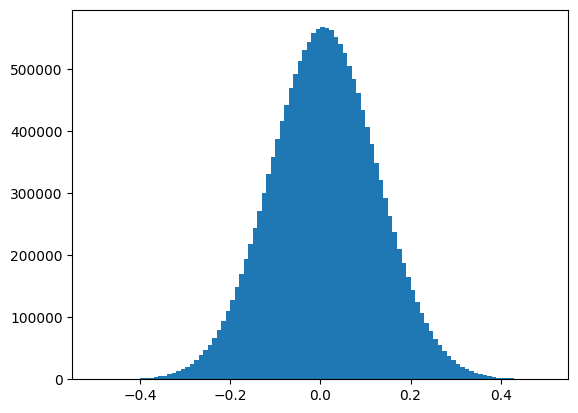

In [49]:
# histogram of b values

plt.hist(b.flatten(), bins=100, range=(-0.5, 0.5))
plt.show()

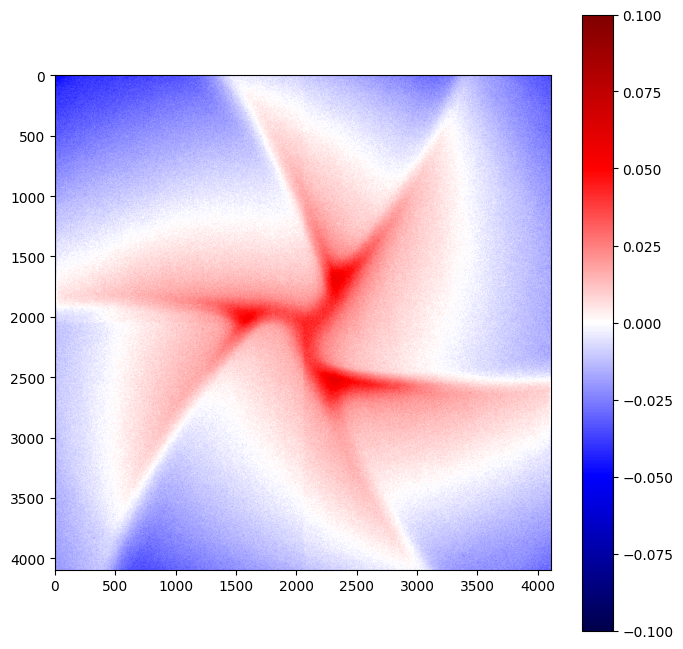

In [79]:
# Now plot in the same way file jk15c_V_master_shutter_map.fits

# shutter_map_file = Path('./maps') / f'{telescope}c_{fltr}_master_shutter_map.fits'
shutter_map_file = Path('./maps') / 'jk15c_median_shutter_map.fits'
# shutter_map_file = '/Users/mka/Downloads/shutter_map1.fits'

shutter_map = pyfits.open(shutter_map_file)[0].data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(shutter_map, cmap='seismic', vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)
plt.show()



(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 1.700000e+01, 8.900000e+01,
        3.450000e+02, 1.239000e+03, 4.079000e+03, 1.172300e+04,
        2.992700e+04, 6.855700e+04, 1.434270e+05, 2.730680e+05,
        4.805040e+05, 7.817190e+05, 1.178195e+06, 1.630534e+06,
        2.039056e+06, 2.270454e+06, 2.218086e+06, 1.889092e+06,
        1.418004e+06, 9.546940e+05, 5.930350e+05, 3.517200e+05,
        2.075870e+05, 1.232980e+05, 7.362300e+04, 4.246100e+04,
        2.295600e+04, 1.121900e+04, 4.82

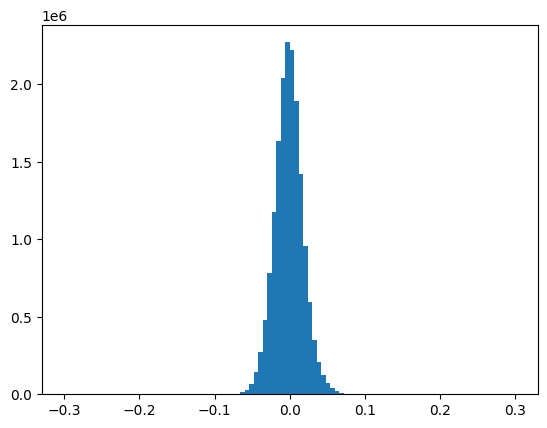

In [80]:
# and histogram of shutter_map values

plt.hist(shutter_map.flatten(), bins=100, range=(-0.3, 0.3))

In [81]:
# variance, mean, median, std of shutter_map values

print(f"variance={np.var(shutter_map):.4f}  mean={np.mean(shutter_map):.4f}  median={np.median(shutter_map):.4f}  std={np.std(shutter_map):.4f}")

variance=0.0004  mean=-0.0012  median=-0.0013  std=0.0188
